# Overview

- Want to use laser distance measurement device, Bosch GLM 165-40 (https://www.boschtools.com/us/en/boschtools-ocs/laser-measures-glm165-40-187965-p/)
- This device only measures distance, so to locate the 3D coordinates of a point in space, e.g. the NMR in the magnet, distance measurements from >=4 locations with known positions are required.
- Testing here the feasibility of this strategy and developing code for calculations.
- If Bosch device is not sufficient, we are also considering something like the Leica Disto 2910 and TRI 200 Pro Pack (https://www.engineersupply.com/Leica-DISTO-S910-and-TRI-200-Pro-Pack-6010741.aspx)

# Imports

In [ ]:
import numpy as np
import lmfit as lm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# %matplotlib inline
%matplotlib notebook

from plotting import config_plots
config_plots()

# Playground

## First Attempt

In [120]:
75/2, 250/2, np.cos(np.pi/4)*250/2

(37.5, 125.0, 88.38834764831844)

In [121]:
#stations = np.array([[-1, -1, -1],[1, 1, 1],[-1, 1, 1],[1, -1, -1]])
#stations = np.array([[-1, -1, -1],[1, 1, 1],[-1, 1, 1],[1, -1, 1]])
##stations = np.array([[37.5, 0, 125.0], [37.5, -125.0, 0], [37.5, 0, -125.0], [37.5, 125.0, 0]])
##stations = np.array([[37.5, 0, 125.0], [37.5, -125.0, 0], [37.5, 0, -125.0], [37.5, 125.0, 0], [-37.5, 0, 125.0]])
##stations = np.array([[37.5, 0, -125.0], [37.5, 125.0, 0], [-37.5, 0, 125.0], [37.5, -125.0, 0]])
stations = np.array([[37.5, 0, 125.0], [37.5, -125.0, 0], [37.5, 0, -125.0], [37.5, 125.0, 0], [37.5, 88.4, 88.4]])

In [122]:
stations.shape

(5, 3)

In [136]:
#test_point = np.array([-0.1, 0., 0.5])
#test_point = np.random.uniform(low=-1, high=1, size=3)
x = np.random.uniform(low=-37.5, high=37.5)
theta = np.random.uniform(low=0, high=2*np.pi)
r = 125.0*(np.random.rand())**(1/2)
y = r*np.cos(theta)
z = r*np.sin(theta)
test_point = np.array([x, y, z])

In [137]:
test_point

array([ 15.84286499, -34.76740083, 118.47140034])

In [138]:
station_meas = np.linalg.norm(np.subtract(stations, test_point), axis=1)

In [139]:
station_meas

array([ 41.47802154, 150.48729564, 246.89294531, 200.07530223,
       128.62165153])

In [140]:
# station_meas_noise = station_meas + np.random.normal(loc=0, scale=2e-3, size=len(station_meas))
station_meas_noise = station_meas + np.random.normal(loc=0, scale=2, size=len(station_meas))

In [141]:
station_meas_noise

array([ 42.26798562, 153.05400005, 248.36027638, 202.4621268 ,
       128.83079558])

## Least-Squares - Easy Solution

In [142]:
def dist2loc(stations, **params):
    x0 = params['x0']
    y0 = params['y0']
    z0 = params['z0']
    test_point = np.array([x0, y0, z0])
    return np.linalg.norm(np.subtract(stations, test_point), axis=1)

In [143]:
model = lm.Model(dist2loc, independent_vars=['stations'])
params = lm.Parameters()
# params.add('x0', value=0, vary=True, min=-1, max=1)
# params.add('y0', value=0, vary=True, min=-1, max=1)
# params.add('z0', value=0, vary=True, min=-1, max=1)

params.add('x0', value=0, vary=True, min=-37.5, max=37.5)
params.add('y0', value=0, vary=True, min=-125., max=125.)
params.add('z0', value=0, vary=True, min=-125., max=125.)

#result = model.fit(station_meas, stations=stations, params=params)
# result = model.fit(station_meas_noise, stations=stations, params=params, weights=1/(2e-3*np.ones_like(station_meas_noise)))
result = model.fit(station_meas_noise, stationss=stations, params=params, weights=1/(2*np.ones_like(station_meas_noise)))

In [144]:
result

In [145]:
test_point

array([ 15.84286499, -34.76740083, 118.47140034])

In [146]:
fit_point = np.array([result.params[f'{i}0'].value for i in ['x','y','z']])

In [147]:
fit_point

array([ 13.46475314, -34.52072503, 120.6020767 ])

In [148]:
np.linalg.norm(fit_point - test_point)

3.202506310768399

## Make a function:

In [297]:
def loc2dist(stations, **params):
    x0 = params['x0']
    y0 = params['y0']
    z0 = params['z0']
    test_point = np.array([[x0, y0, z0]])
    return np.linalg.norm(np.subtract(stations, test_point), axis=1)

In [373]:
s_ = np.array([[-10, 0, 0]])
t_ = np.array([[0, 0, 0]])
td = {'x0': t_[0,0], 'y0': t_[0,1], 'z0': t_[0,2]}
loc2dist(s_, **td)

array([10.])

In [376]:
np.linalg.norm(np.subtract(s_, t_), axis=1)

array([10.])

In [298]:
def generate_test_points_GMW(N=1):
    x = np.random.uniform(low=-37.5, high=37.5, size=N)
    theta = np.random.uniform(low=0, high=2*np.pi, size=N)
    r = 125.0*(np.random.rand(N))**(1/2)
    y = r*np.cos(theta)
    z = r*np.sin(theta)
    #if N > 1:
    test_points = np.array([x, y, z]).T
    #else:
    #    test_points = np.array([[]])
    return test_points

In [416]:
def triangulate_GMW(test_point, stations, noise_level=2, init_vals=[0.,0.,0.], vary_z=True):
    station_meas = np.linalg.norm(np.subtract(stations, test_point), axis=1)
    station_meas_noise = station_meas + np.random.normal(loc=0, scale=noise_level, size=len(station_meas))
    model = lm.Model(loc2dist, independent_vars=['stations'])
    params = lm.Parameters()

    params.add('x0', value=init_vals[0], vary=True, min=-37.5, max=37.5)
    params.add('y0', value=init_vals[1], vary=True, min=-125., max=125.)
    params.add('z0', value=init_vals[2], vary=vary_z, min=-125., max=125.)

    result = model.fit(station_meas_noise, stations=stations, params=params,
                       weights=1/(noise_level*np.ones_like(station_meas_noise)),
                       #weights=1/(station_meas_noise),
                       method='least_squares')
    fit_point = np.array([result.params[f'{i}0'].value for i in ['x', 'y', 'z']])
    
    return fit_point, result, station_meas, station_meas_noise

def triangulate_GMW_grid(test_point, stations, noise_level=2,
                         xs=np.linspace(-37.5, 37.5, 751),
                         ys=np.linspace(-125., 125., 250),
                         zs=np.linspace(-125., 125., 250)):
    station_meas = np.linalg.norm(np.subtract(stations, test_point), axis=1)
    station_meas_noise = station_meas + np.random.normal(loc=0, scale=noise_level, size=len(station_meas))
    
    x_grid = []; y_grid = []; z_grid = []
    misfit_grid = []
    misfit_grid_noise = []
    
    for x in xs:
        for y in ys:
            for z in zs:
                #misfit = np.linalg.norm(loc2dist(stations, x0=x, y0=y, z0=z)-station_meas_noise)**2/noise_level**2
                misfit_n = np.linalg.norm(loc2dist(stations, x0=x, y0=y, z0=z)-station_meas_noise)
                misfit_grid_noise.append(misfit_n)
                misfit = np.linalg.norm(loc2dist(stations, x0=x, y0=y, z0=z)-station_meas)
                misfit_grid.append(misfit)
                x_grid.append(x)
                y_grid.append(y)
                z_grid.append(z)
    return np.array(misfit_grid), np.array(misfit_grid_noise),\
           np.array(x_grid), np.array(y_grid), np.array(z_grid),\
           station_meas, station_meas_noise

In [479]:
#stations = np.array([[-1, -1, -1],[1, 1, 1],[-1, 1, 1],[1, -1, -1]])
#stations = np.array([[-1, -1, -1],[1, 1, 1],[-1, 1, 1],[1, -1, 1]])

# stations = np.array([[37.5, 0, 125.0], [37.5, -125.0, 0], [37.5, 0, -125.0], [37.5, 125.0, 0]])
# stations2 = np.array([[-37.5, 0, 125.0], [-37.5, -125.0, 0], [-37.5, 0, -125.0], [-37.5, 125.0, 0],])

stations = np.array([[37.5, 0, 250.0], [37.5, -125.0, 0], [37.5, 0, -125.0], [37.5, 200.0, 0]])


#stations = np.array([[37.5, 0, 125.0], [37.5, -125.0, 0], [37.5, 0, -125.0], [37.5, 125.0, 0], [-37.5, 0, 125.0]])
# stations = np.array([[37.5, 0, -125.0], [37.5, 125.0, 0], [-37.5, 0, 125.0], [37.5, -125.0, 0]])
# stations = np.array([[37.5, 0, 125.0], [37.5, -125.0, 0], [37.5, 0, -125.0], [37.5, 125.0, 0], [37.5, 88.4, 88.4]])
# stations = np.array([[37.5, 0, 125.0], [37.5, -125.0, 0], [37.5, 0, -125.0], [37.5, 125.0, 0],
#                      [-37.5, 88.4, 88.4], [-37.5, 88.4, -88.4], [-37.5, -88.4, -88.4], [-37.5, -88.4, 88.4],])
# stations = np.array([[37.5, 0, 125.0], [37.5, -125.0, 0], [37.5, 0, -125.0], [37.5, 125.0, 0],
#                      [-37.5, 0, 125.0], [-37.5, -125.0, 0], [-37.5, 0, -125.0], [-37.5, 125.0, 0],
#                      [-37.5, 88.4, 88.4], [-37.5, 88.4, -88.4], [-37.5, -88.4, -88.4], [-37.5, -88.4, 88.4],
#                      [37.5, 88.4, 88.4], [37.5, 88.4, -88.4], [37.5, -88.4, -88.4], [37.5, -88.4, 88.4],
#                      [0, 88.4, 88.4]
#                     ])

In [443]:
test_points = generate_test_points_GMW(1000)

### TESTING

In [378]:
i = 1
_ =  triangulate_GMW_grid(test_points[i], stations, noise_level=2,
                                            xs=np.linspace(-37.5, 37.5, 10),#76),
                                            ys=np.linspace(-125., 125., 10),#250),
                                            zs=np.linspace(-125., 125., 10))#250))
mg, mgn, xg, yg, zg, meas, meas_n = _

In [379]:
meas, meas_n

(array([154.70264391,  23.86142747, 177.30057316, 234.09193398,
        168.2182585 ,  70.24131393, 189.20879394, 243.23549908,
        220.39848186, 232.1234996 , 124.61981941, 101.11513798,
        210.26415849, 222.52380683, 105.66752069,  76.54930874,
        212.10139928]),
 array([150.90202466,  24.94889438, 178.39937459, 235.75782959,
        169.3888144 ,  69.52383688, 192.47203321, 243.18423461,
        222.80767364, 228.93662257, 127.68256622,  94.32815624,
        211.06718824, 224.05187049, 104.20964214,  75.39343203,
        210.66251414]))

In [380]:
mg, mgn

(array([354.29004555, 293.02654209, 232.23673365, 174.01409358,
        131.93400396, 111.47658553, 124.10633825, 171.59462284,
        229.2541439 , 290.42602248, 343.7079406 , 290.95261489,
        231.40790201, 169.34395348, 120.32160613,  98.2259918 ,
        119.01278157, 171.31058284, 227.26734316, 279.25020352,
        350.47225171, 301.62860549, 248.47308808, 194.52211543,
        153.36732306, 138.32287407, 156.81736321, 198.81138498,
        245.80984486, 291.63604274, 372.88328611, 327.30301972,
        281.07281785, 238.94493811, 209.45114792, 200.60709809,
        214.6309588 , 245.49782805, 283.8905207 , 323.94367825,
        409.32361312, 367.03792555, 326.61475885, 293.62165276,
        272.77732574, 268.00489535, 279.62109864, 304.01380983,
        336.43150888, 371.49537316, 443.73871383, 409.11900002,
        376.956646  , 351.82242347, 337.14805914, 335.2109509 ,
        345.61746098, 365.29635781, 390.33199848, 416.80528671,
        475.02835575, 451.31183081, 428.

In [381]:
ts = np.linspace(0, 2*np.pi, 100)
xs_n = -37.5 * np.ones_like(ts)
xs_p = 37.5 * np.ones_like(ts)
ys = 125 * np.cos(ts)
zs = 125 * np.sin(ts)
verts_n = [list(zip(xs_n, ys, zs))]
verts_p = [list(zip(xs_p, ys, zs))]

<IPython.core.display.Javascript object>


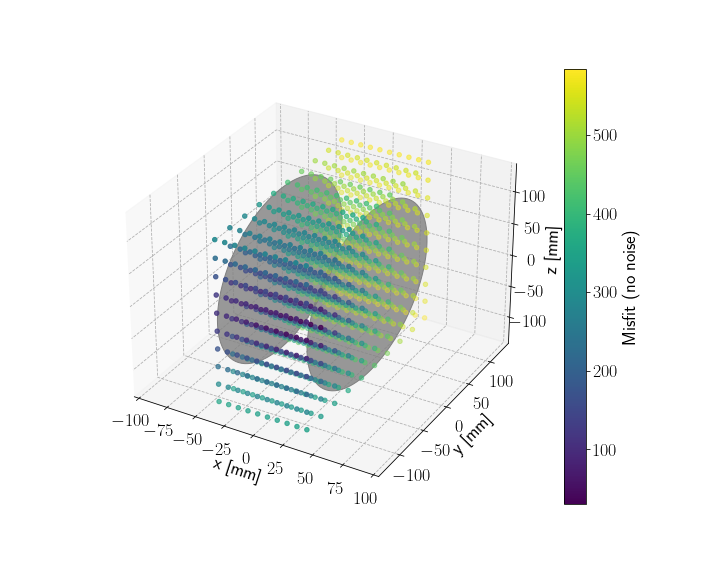

<IPython.core.display.Javascript object>


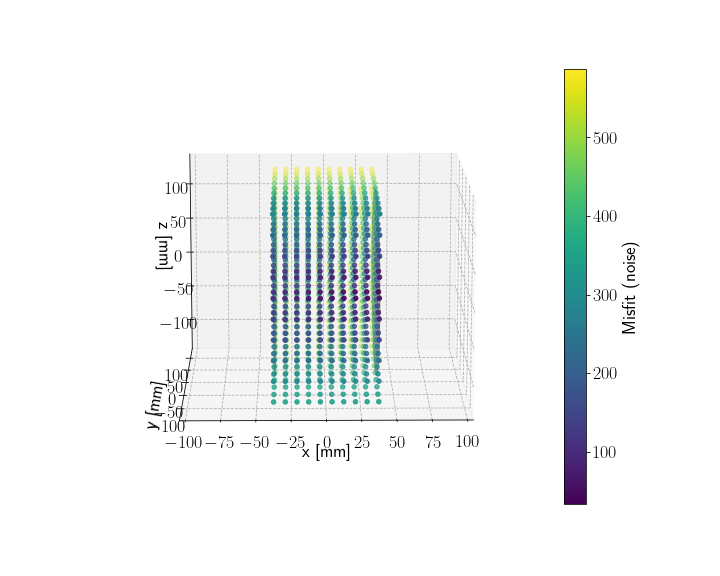

In [382]:
for m_, na in zip([mg, mgn], [' (no noise)', ' (noise)']):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    sc = ax.scatter(xg, yg, zg, c=m_)
    cb = fig.colorbar(sc, label=f'Misfit{na}')

    ax.add_collection3d(Poly3DCollection(verts_n, color='gray', alpha=0.8))#, zs='z')
    ax.add_collection3d(Poly3DCollection(verts_p, color='gray', alpha=0.8))

    # ax.set_aspect('equal')
    ax.set_xlim3d([-100, 100])

    # ax.plot_trisurf(xs_n, ys, zs, color='red', edgecolor='none');

    ax.set_xlabel('x [mm]')
    ax.set_ylabel('y [mm]')
    ax.set_zlabel('z [mm]');

In [383]:
test_points[i]

array([  29.09649641, -108.45933166,   15.00517042])

In [384]:
imin = np.argmin(mg)

In [385]:
mg[imin]

30.579302887258905

In [386]:
xg[imin], yg[imin], zg[imin]

(37.5, -97.22222222222223, 13.888888888888886)

In [ ]:
_ = triangulate_GMW(test_points[i], stations, init_vals=[x_, y_, z_])
fit_point, result, station_meas, staion_meas_noise = _
#print(init_x, fit_point, test_points[i], result.redchi)
print(f'{x_:.1f}, {y_:.1f}, {z_:.1f}', fit_point, test_points[i], result.redchi)

In [367]:
loc2dist(stations, x0=test_points[i][0], y0=test_points[i][1], z0=test_points[i][2])\
-loc2dist(stations, x0=test_points[i][0]+0.1, y0=test_points[i][1]-1, z0=test_points[i][2]-1)

array([-1.40675893,  1.35353235,  0.17708272, -0.93204602, -1.33887085,
        0.34081462,  0.12625819, -0.92785942, -1.25739654, -0.43521705,
        0.60878356, -0.99513942, -1.28218151, -0.42031673,  0.79015158,
       -1.21337055, -1.28871576])

In [368]:
loc2dist(stations, x0=test_points[i][0], y0=test_points[i][1], z0=test_points[i][2])

array([154.70264391,  23.86142747, 177.30057316, 234.09193398,
       168.2182585 ,  70.24131393, 189.20879394, 243.23549908,
       220.39848186, 232.1234996 , 124.61981941, 101.11513798,
       210.26415849, 222.52380683, 105.66752069,  76.54930874,
       212.10139928])

In [369]:
meas

array([ 41.47802154, 150.48729564, 246.89294531, 200.07530223,
        64.0066873 , 158.18614319, 251.65960381, 205.92852234,
       137.54984184, 246.59976916, 220.26732218,  81.4015114 ,
       128.62165153, 241.73335807, 214.80517561,  65.1903084 ,
       127.77125701])

In [377]:
np.linalg.norm(np.subtract(stations, test_points[i]), axis=1)

array([154.70264391,  23.86142747, 177.30057316, 234.09193398,
       168.2182585 ,  70.24131393, 189.20879394, 243.23549908,
       220.39848186, 232.1234996 , 124.61981941, 101.11513798,
       210.26415849, 222.52380683, 105.66752069,  76.54930874,
       212.10139928])

In [375]:
loc2dist(stations, x0=test_points[i][0], y0=test_points[i][1], z0=test_points[i][2])

array([154.70264391,  23.86142747, 177.30057316, 234.09193398,
       168.2182585 ,  70.24131393, 189.20879394, 243.23549908,
       220.39848186, 232.1234996 , 124.61981941, 101.11513798,
       210.26415849, 222.52380683, 105.66752069,  76.54930874,
       212.10139928])

In [291]:
250*250*76

4750000

In [262]:
stations

array([[  37.5,    0. ,  125. ],
       [  37.5, -125. ,    0. ],
       [  37.5,    0. , -125. ],
       [  37.5,  125. ,    0. ],
       [ -37.5,    0. ,  125. ],
       [ -37.5, -125. ,    0. ],
       [ -37.5,    0. , -125. ],
       [ -37.5,  125. ,    0. ],
       [ -37.5,   88.4,   88.4],
       [ -37.5,   88.4,  -88.4],
       [ -37.5,  -88.4,  -88.4],
       [ -37.5,  -88.4,   88.4],
       [  37.5,   88.4,   88.4],
       [  37.5,   88.4,  -88.4],
       [  37.5,  -88.4,  -88.4],
       [  37.5,  -88.4,   88.4]])

In [263]:
test_points[1]

array([-29.57925916,  96.48421429,  29.81070084])

In [264]:
station_meas

array([ 78.92273164, 117.16504694, 180.29519419, 158.13761853,
       128.20324107, 187.13514123, 164.44587372,  91.97257918])

In [417]:
i = 2
N = 10
ixs = np.random.uniform(low=-37.5, high=37.5, size=N)
theta = np.random.uniform(low=0, high=2*np.pi, size=N)
r = 125.0*(np.random.rand(N))**(1/2)
iys = r*np.cos(theta)
izs = r*np.sin(theta)
# for init_x in [-30, -15, 0, 15, 30]:
for x_, y_, z_ in zip(ixs, iys, izs):
#     _ = triangulate_GMW(test_points[i], stations, init_vals=[init_x, 0, 0])
    _ = triangulate_GMW(test_points[i], stations, init_vals=[x_, y_, z_])#, noise_level= 1.5875)
    fit_point, result, station_meas, staion_meas_noise = _
    #print(init_x, fit_point, test_points[i], result.redchi)
    print(f'{x_:.1f}, {y_:.1f}, {z_:.1f}', fit_point, test_points[i], result.redchi)

-19.0, -43.5, -4.7 [ 33.00396269 -92.2515118    6.38981576] [ 31.97494514 -92.03245275   7.01350356] 2.1057797606545092
-11.5, 29.8, -63.4 [ 34.12705945 -92.47745309   7.41703415] [ 31.97494514 -92.03245275   7.01350356] 0.2401492747272122
0.9, -8.3, -77.2 [ 32.06892922 -91.83894615   7.75408669] [ 31.97494514 -92.03245275   7.01350356] 1.2563021056085433
-34.9, 115.8, 31.9 [ 29.95363113 -92.59374415   5.03737075] [ 31.97494514 -92.03245275   7.01350356] 1.3055119917708766
-36.9, 43.1, -60.1 [ 30.13465184 -90.61464272   5.03591381] [ 31.97494514 -92.03245275   7.01350356] 1.1488562411367522
5.0, -8.5, 123.6 [ 30.88190788 -91.88356789   6.9153822 ] [ 31.97494514 -92.03245275   7.01350356] 0.4226560170171326
5.3, 106.4, -31.7 [ 29.84054633 -92.69374326   6.81636553] [ 31.97494514 -92.03245275   7.01350356] 0.3996439766119533
25.0, -11.0, 20.1 [ 29.15363646 -91.42055175   7.13515345] [ 31.97494514 -92.03245275   7.01350356] 0.19049452496504787
-15.8, 45.2, -46.0 [ 36.62819098 -92.20755341

### Working

In [480]:
#i = 2

misfit_dists = []
mis_xs = []; mis_ys = []; mis_zs = []

# for init_x in [-30, -15, 0, 15, 30]:
#for x_, y_, z_ in zip(ixs, iys, izs):
for i in range(len(test_points)):
#     _ = triangulate_GMW(test_points[i], stations, init_vals=[init_x, 0, 0])
#     _ = triangulate_GMW(test_points[i], stations, init_vals=[0, 0, 0])
    
    sta = stations
    
#     if test_points[i][0] < 0:
#         sta = stations
#     else:
#         sta = stations2

    _ = triangulate_GMW(test_points[i], sta, init_vals=[0, 0, 0], noise_level=1.5875)
    fit_point, result, station_meas, staion_meas_noise = _
    diffs = fit_point-test_points[i]
    mis_xs.append(diffs[0])
    mis_ys.append(diffs[1])
    mis_zs.append(diffs[2])
    misfit_dist = np.linalg.norm(diffs)
    misfit_dists.append(misfit_dist)
    #print(init_x, fit_point, test_points[i], result.redchi)
#     print(f'{i}', fit_point, test_points[i], result.redchi)
misfit_dists = np.array(misfit_dists)
mis_xs = np.array(mis_xs)
mis_ys = np.array(mis_ys)
mis_zs = np.array(mis_zs)

In [481]:
np.mean(misfit_dists), np.std(misfit_dists)

(4.1277467134658705, 3.3284978393730094)

In [482]:
np.mean(mis_xs), np.std(mis_xs)

(0.031101442300067943, 5.024580180386777)

In [483]:
np.mean(mis_ys), np.std(mis_ys)

(-0.04723927739340323, 1.2202969361053)

In [484]:
np.mean(mis_zs), np.std(mis_zs)

(0.009398696966773208, 1.1740413158356173)

In [485]:
np.max(np.abs(mis_xs)), np.max(np.abs(mis_ys)), np.max(np.abs(mis_zs))

(22.7098598229378, 4.527295491714838, 3.991321987954027)

<IPython.core.display.Javascript object>


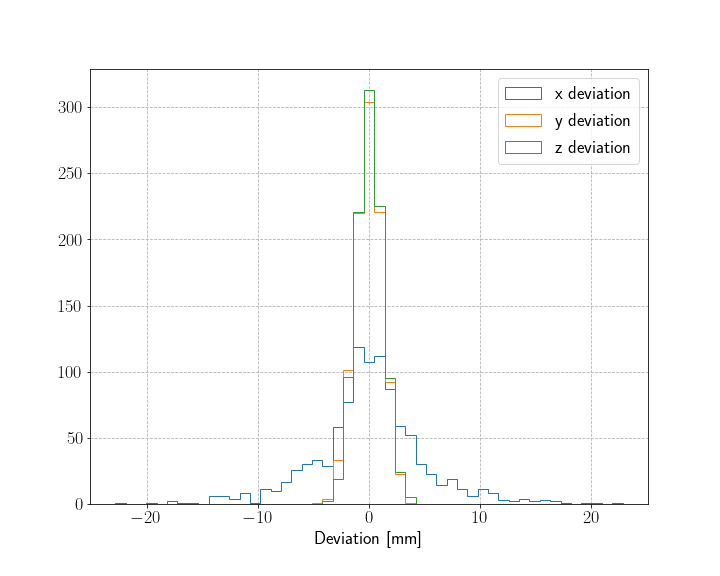

In [486]:
fig, ax = plt.subplots()

dmax = 0.1 + np.max([np.max(np.abs(mis_xs)), np.max(np.abs(mis_ys)), np.max(np.abs(mis_zs))])
bins = np.linspace(-dmax, dmax, 50)

ax.hist(mis_xs, histtype='step', bins=bins, label='x deviation')
ax.hist(mis_ys, histtype='step', bins=bins, label='y deviation')
ax.hist(mis_zs, histtype='step', bins=bins, label='z deviation')

ax.set_xlabel('Deviation [mm]')
ax.legend();

In [487]:
test_rs = np.linalg.norm(test_points[:, 1:], axis=1)

<IPython.core.display.Javascript object>


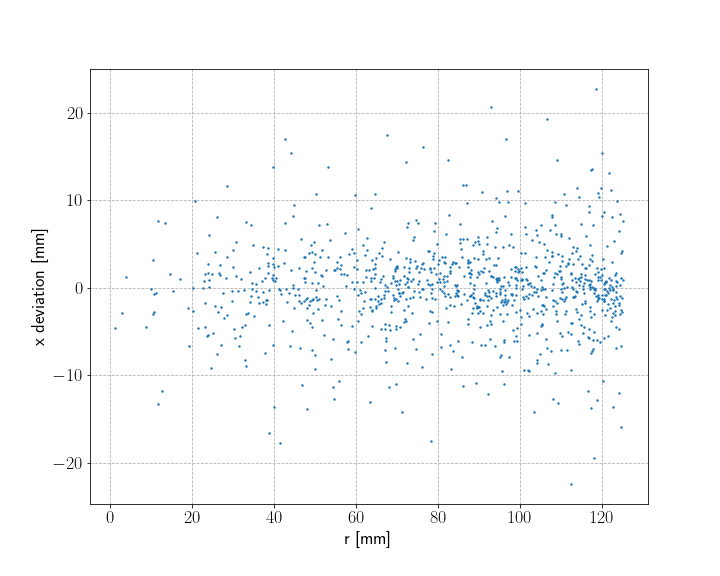

<IPython.core.display.Javascript object>


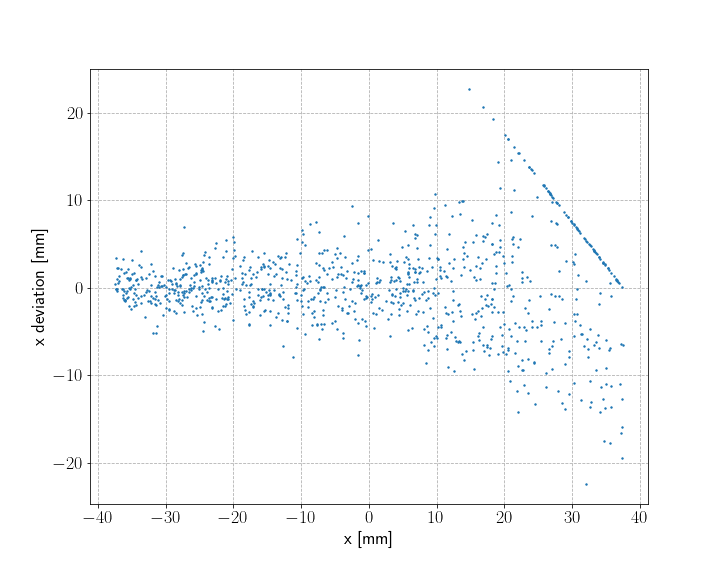

<IPython.core.display.Javascript object>


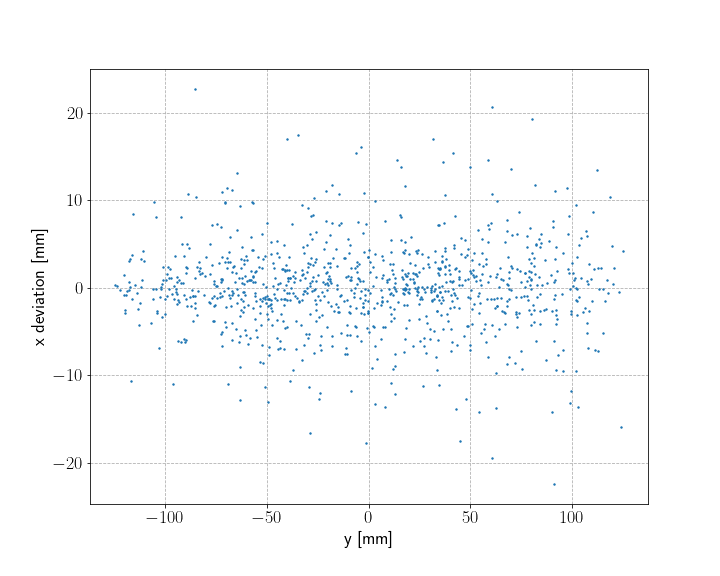

<IPython.core.display.Javascript object>


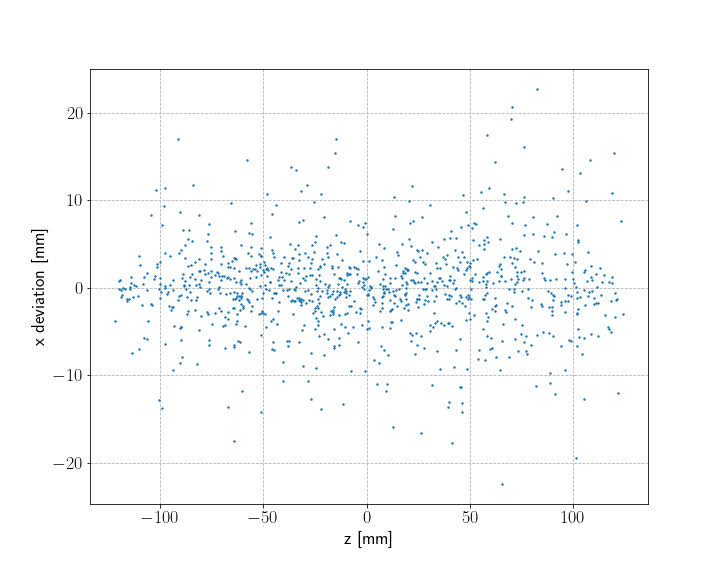

In [488]:
fig, ax = plt.subplots()
ax.scatter(test_rs, mis_xs, s=2)
ax.set_xlabel('r [mm]')
ax.set_ylabel('x deviation [mm]');

fig, ax = plt.subplots()
ax.scatter(test_points[:, 0], mis_xs, s=2)
ax.set_xlabel('x [mm]')
ax.set_ylabel('x deviation [mm]');

fig, ax = plt.subplots()
ax.scatter(test_points[:, 1], mis_xs, s=2)
ax.set_xlabel('y [mm]')
ax.set_ylabel('x deviation [mm]');

fig, ax = plt.subplots()
ax.scatter(test_points[:, 2], mis_xs, s=2)
ax.set_xlabel('z [mm]')
ax.set_ylabel('x deviation [mm]');

In [209]:
fit_point, test_points[0]

(array([32.68792558, 97.31909208, 56.7653526 ]),
 array([23.91150533, 97.7260384 , 57.62040467]))

In [171]:
75/2

37.5

In [188]:
ts = np.linspace(0, 2*np.pi, 100)
xs_n = -37.5 * np.ones_like(ts)
xs_p = 37.5 * np.ones_like(ts)
ys = 125 * np.cos(ts)
zs = 125 * np.sin(ts)
verts_n = [list(zip(xs_n, ys, zs))]
verts_p = [list(zip(xs_p, ys, zs))]
#verts_n = np.array([xs_n, ys, zs])
# verts_p = np.array([xs_p, ys, zs])

<IPython.core.display.Javascript object>


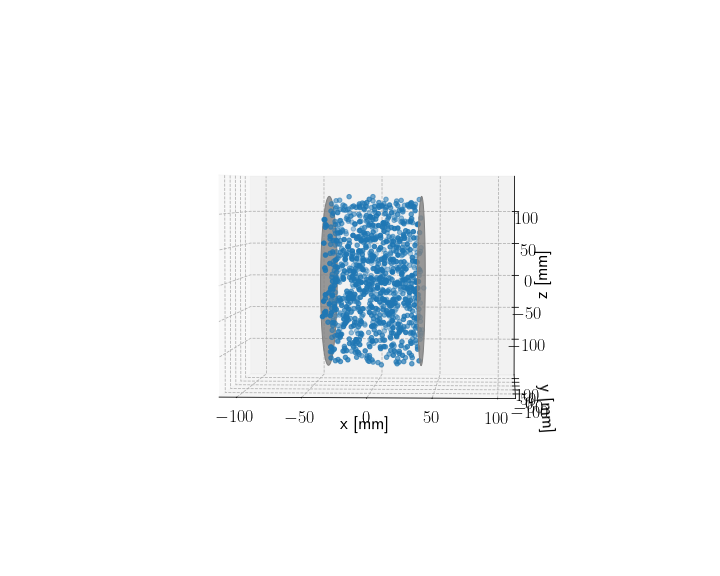

In [193]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*test_points.T)

ax.add_collection3d(Poly3DCollection(verts_n, color='gray', alpha=0.8))#, zs='z')
ax.add_collection3d(Poly3DCollection(verts_p, color='gray', alpha=0.8))

# ax.set_aspect('equal')
ax.set_xlim3d([-100, 100])

# ax.plot_trisurf(xs_n, ys, zs, color='red', edgecolor='none');

ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
ax.set_zlabel('z [mm]');

# 2D Triangulation (NMR Location)

- During first day of FNAL measurements, used mm tape measure to estimate NMR distance from brass spacers. This required also estimating the locations of the precision brass.
- All of the measurements are assumed to exist on the pole face. A correction for the sample location off of the pole can be added after the fit.
- Note that coordinate system used here has the origin at the lower left hand corner of the square s.t. the circular pole face is inscribed
- y measurements are offset by 25 mm, from the vertical 80/20 piece used to estimate spacer locations

In [495]:
def loc2dist_2d(stations, **params):
    #x0 = params['x0']
    y0 = params['y0']
    z0 = params['z0']
    #test_point = np.array([[x0, y0, z0]])
    test_point = np.array([[y0, z0]])
    return np.linalg.norm(np.subtract(stations, test_point), axis=1)

# def generate_test_points_GMW_2d(N=1):
# #     x = np.random.uniform(low=-37.5, high=37.5, size=N)
#     theta = np.random.uniform(low=0, high=2*np.pi, size=N)
#     r = 125.0*(np.random.rand(N))**(1/2)
#     y = r*np.cos(theta)
#     z = r*np.sin(theta)
#     #if N > 1:
# #     test_points = np.array([x, y, z]).T
#     test_points = np.array([y, z]).T
#     #else:
#     #    test_points = np.array([[]])
#     return test_points

def triangulate_GMW_2d(test_point, stations, noise_level=2, init_vals=[0.,0.]):
    station_meas = np.linalg.norm(np.subtract(stations, test_point), axis=1)
    station_meas_noise = station_meas + np.random.normal(loc=0, scale=noise_level, size=len(station_meas))
    model = lm.Model(loc2dist_2d, independent_vars=['stations'])
    params = lm.Parameters()

#     params.add('x0', value=init_vals[0], vary=True, min=-37.5, max=37.5)
    params.add('y0', value=init_vals[0], vary=True, min=0., max=250.)
    params.add('z0', value=init_vals[1], vary=True, min=0, max=250.)

    result = model.fit(station_meas_noise, stations=stations, params=params,
                       weights=1/(noise_level*np.ones_like(station_meas_noise)),
                       #weights=1/(station_meas_noise),
                       method='least_squares')
    fit_point = np.array([result.params[f'{i}0'].value for i in ['y', 'z']])
    
    return fit_point, result, station_meas, station_meas_noise

def triangulate_GMW_2d_data(meas_dists, stations, noise_level=2, init_vals=[0.,0.]):
    #station_meas = np.linalg.norm(np.subtract(stations, test_point), axis=1)
    #station_meas_noise = station_meas + np.random.normal(loc=0, scale=noise_level, size=len(station_meas))
    staion_meas_noise = meas_dists
    model = lm.Model(loc2dist_2d, independent_vars=['stations'])
    params = lm.Parameters()

#     params.add('x0', value=init_vals[0], vary=True, min=-37.5, max=37.5)
    params.add('y0', value=init_vals[0], vary=True, min=0., max=250.)
    params.add('z0', value=init_vals[1], vary=True, min=0., max=250.)

    result = model.fit(station_meas_noise, stations=stations, params=params,
                       weights=1/(noise_level*np.ones_like(station_meas_noise)),
                       #weights=1/(station_meas_noise),
                       method='least_squares')
    fit_point = np.array([result.params[f'{i}0'].value for i in ['y', 'z']])
    
    return fit_point, result, station_meas, station_meas_noise


# def triangulate_GMW_grid_2d(test_point, stations, noise_level=2,
#                             xs=np.linspace(-37.5, 37.5, 751),
#                             ys=np.linspace(-125., 125., 250),
#                             zs=np.linspace(-125., 125., 250)):
#     station_meas = np.linalg.norm(np.subtract(stations, test_point), axis=1)
#     station_meas_noise = station_meas + np.random.normal(loc=0, scale=noise_level, size=len(station_meas))
    
#     x_grid = []; y_grid = []; z_grid = []
#     misfit_grid = []
#     misfit_grid_noise = []
    
#     for x in xs:
#         for y in ys:
#             for z in zs:
#                 #misfit = np.linalg.norm(loc2dist(stations, x0=x, y0=y, z0=z)-station_meas_noise)**2/noise_level**2
#                 misfit_n = np.linalg.norm(loc2dist(stations, x0=x, y0=y, z0=z)-station_meas_noise)
#                 misfit_grid_noise.append(misfit_n)
#                 misfit = np.linalg.norm(loc2dist(stations, x0=x, y0=y, z0=z)-station_meas)
#                 misfit_grid.append(misfit)
#                 x_grid.append(x)
#                 y_grid.append(y)
#                 z_grid.append(z)
#     return np.array(misfit_grid), np.array(misfit_grid_noise),\
#            np.array(x_grid), np.array(y_grid), np.array(z_grid),\
#            station_meas, station_meas_noise

In [618]:
spacer_diameter = 19.33 # mm, measured with micrometer
y_offset = 25 # mm, width of 80/2, tape measure
#spacers = np.array([
# all station units mm
stations = np.array([
    [51. + spacer_diameter/2 - y_offset, 50.],
    [136. + spacer_diameter/2 - y_offset, 230. + spacer_diameter/2],
    [226. + spacer_diameter/2 - y_offset, 47.]
    #[222. + spacer_diameter/2 - y_offset, 47.] # correction from tape
    #[223. + spacer_diameter/2 - y_offset, 47.] # correction from tape
])

meas_dists = np.array([109.75, 93.31, 117.57]) + spacer_diameter/2 # mm, measured with micrometer

nmr_tape_est = np.array([125., 136.])

In [619]:
meas_dists

array([119.415, 102.975, 127.235])

In [620]:
stations

array([[ 35.665,  50.   ],
       [120.665, 239.665],
       [210.665,  47.   ]])

In [621]:
params = {'y0':125., 'z0':125.}

In [622]:
loc2dist_2d(stations, **params)

array([116.64365489, 114.74691477, 115.85547991])

In [623]:
model = lm.Model(loc2dist_2d, independent_vars=['stations'])
params = lm.Parameters()
params.add('y0', value=125., vary=True, min=0, max=250.)
params.add('z0', value=125., vary=True, min=0, max=250.)
result = model.fit(meas_dists, stations=stations, params=params)
nmr_best_fit = np.array([result.params[f'{i}0'].value for i in ['y', 'z']])

In [624]:
result

In [625]:
ts = np.linspace(0, 2*np.pi, 501)
ys = 125. + 125.*np.cos(ts)
zs = 125. + 125.*np.sin(ts)

<IPython.core.display.Javascript object>


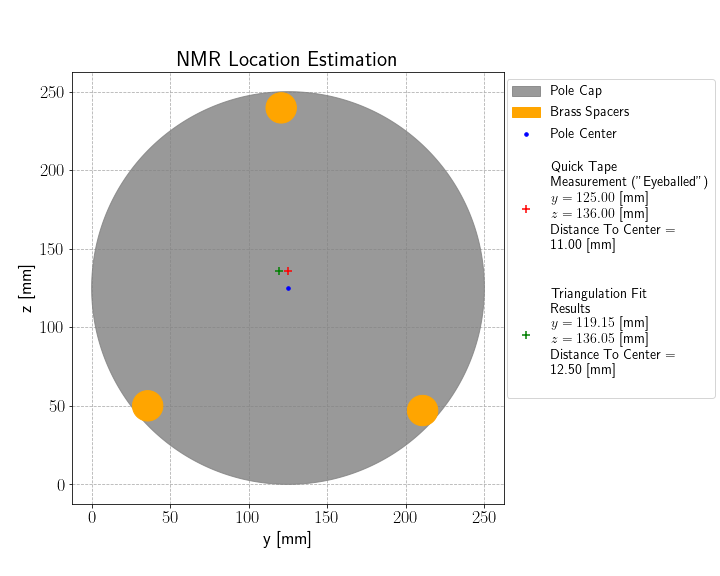

In [626]:
#fig, ax = plt.subplots()
fig = plt.figure()
ax = fig.add_axes((0.1, 0.1, 0.6, 0.8))
#ax2 = fig.add_axes((0.72, 0.08, 0.25, 0.8))

#ax.plot(ys, zs, label='Pole Cap', zorder=50)
ax.fill(ys, zs, label='Pole Cap', color='gray', alpha=0.8, zorder=50)

ax.scatter([125.], [125.], s=50, marker='.', color='blue', label='Pole Center', zorder=52)

for i, sta in enumerate(stations):
    y_ = sta[0] + spacer_diameter/2 * np.cos(ts)
    z_ = sta[1] + spacer_diameter/2 * np.sin(ts)
    l = None
    if i == 0:
        l = 'Brass Spacers'
    ax.fill(y_, z_, label=l, color='orange', zorder=51)
#ax.scatter(*stations.T, s=25, c='orange', label='Brass Spacers')
center = np.array([125., 125.])
d_est = np.linalg.norm(nmr_tape_est-center)
d_fit = np.linalg.norm(nmr_best_fit-center)

ax.scatter([nmr_tape_est[0]], [nmr_tape_est[1]], c='red', marker='+', s=50, zorder=53,
           label='\nQuick Tape\nMeasurement ("Eyeballed")\n'+rf'$y={nmr_tape_est[0]:0.2f}$'+' [mm]\n'+
          rf'$z={nmr_tape_est[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_est:0.2f} [mm]\n')
ax.scatter([nmr_best_fit[0]], [nmr_best_fit[1]], c='green', marker='+', s=50, zorder=54,
           label='\nTriangulation Fit\nResults\n'+rf'$y={nmr_best_fit[0]:0.2f}$'+' [mm]\n'+
          rf'$z={nmr_best_fit[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_fit:0.2f} [mm]\n')


ax.set_xlabel('y [mm]')
ax.set_ylabel('z [mm]')
ax.set_title('NMR Location Estimation')
ax.set_aspect('equal')
ax.legend(fontsize=14, bbox_to_anchor=(0.99,1.0), loc="upper left").set_zorder(100);
#ax2.legend(fontsize=14,).set_zorder(100) #bbox_to_anchor=(0.75,1.0), loc="upper left").set_zorder(100);
fig.savefig('NMR_loc.pdf', transparent=False)
fig.savefig('NMR_loc.png', transparent=False)

In [627]:
_ = triangulate_GMW_2d_data(meas_dists, stations, init_vals=[125., 125.], noise_level=1.5875)
fit_point, result, station_meas, staion_meas_noise = _

ValueError: operands could not be broadcast together with shapes (3,) (5,) 

In [628]:
#stations = np.array([[-1, -1, -1],[1, 1, 1],[-1, 1, 1],[1, -1, -1]])
#stations = np.array([[-1, -1, -1],[1, 1, 1],[-1, 1, 1],[1, -1, 1]])

# stations = np.array([[37.5, 0, 125.0], [37.5, -125.0, 0], [37.5, 0, -125.0], [37.5, 125.0, 0]])
# stations2 = np.array([[-37.5, 0, 125.0], [-37.5, -125.0, 0], [-37.5, 0, -125.0], [-37.5, 125.0, 0],])

stations = np.array([[37.5, 0, 250.0], [37.5, -125.0, 0], [37.5, 0, -125.0], [37.5, 200.0, 0]])


#stations = np.array([[37.5, 0, 125.0], [37.5, -125.0, 0], [37.5, 0, -125.0], [37.5, 125.0, 0], [-37.5, 0, 125.0]])
# stations = np.array([[37.5, 0, -125.0], [37.5, 125.0, 0], [-37.5, 0, 125.0], [37.5, -125.0, 0]])
# stations = np.array([[37.5, 0, 125.0], [37.5, -125.0, 0], [37.5, 0, -125.0], [37.5, 125.0, 0], [37.5, 88.4, 88.4]])
# stations = np.array([[37.5, 0, 125.0], [37.5, -125.0, 0], [37.5, 0, -125.0], [37.5, 125.0, 0],
#                      [-37.5, 88.4, 88.4], [-37.5, 88.4, -88.4], [-37.5, -88.4, -88.4], [-37.5, -88.4, 88.4],])
# stations = np.array([[37.5, 0, 125.0], [37.5, -125.0, 0], [37.5, 0, -125.0], [37.5, 125.0, 0],
#                      [-37.5, 0, 125.0], [-37.5, -125.0, 0], [-37.5, 0, -125.0], [-37.5, 125.0, 0],
#                      [-37.5, 88.4, 88.4], [-37.5, 88.4, -88.4], [-37.5, -88.4, -88.4], [-37.5, -88.4, 88.4],
#                      [37.5, 88.4, 88.4], [37.5, 88.4, -88.4], [37.5, -88.4, -88.4], [37.5, -88.4, 88.4],
#                      [0, 88.4, 88.4]
#                     ])

# Day 2

## Second Set of Measurements for NMR
- Marked with an "x" the location of the NMR sample within the probe head (4 mm from end). Repeated micrometer and "quick" estimate with careful location of NMR

In [699]:
spacer_diameter = 19.33 # mm, measured with micrometer
y_offset = 25 # mm, width of 80/2, tape measure
#spacers = np.array([
# all station units mm
stations = np.array([
    [51. + spacer_diameter/2 - y_offset, 50.],
    [136. + spacer_diameter/2 - y_offset, 230. + spacer_diameter/2],
    [226. + spacer_diameter/2 - y_offset, 47.]
    #[222. + spacer_diameter/2 - y_offset, 47.] # correction from tape
    #[223. + spacer_diameter/2 - y_offset, 47.] # correction from tape
])

meas_dists = np.array([112.78, 93.92, 112.69]) + spacer_diameter/2 # mm, measured with micrometer

nmr_tape_est = np.array([125., 135.]) # maybe 135.5
# nmr_tape_est = np.array([125., 135.5]) # maybe 135.5

In [700]:
meas_dists

array([122.445, 103.585, 122.355])

In [701]:
stations

array([[ 35.665,  50.   ],
       [120.665, 239.665],
       [210.665,  47.   ]])

In [702]:
params = {'y0':125., 'z0':125.}

In [703]:
loc2dist_2d(stations, **params)

array([116.64365489, 114.74691477, 115.85547991])

In [704]:
model = lm.Model(loc2dist_2d, independent_vars=['stations'])
params = lm.Parameters()
params.add('y0', value=125., vary=True, min=0, max=250.)
params.add('z0', value=125., vary=True, min=0, max=250.)
result = model.fit(meas_dists, stations=stations, params=params)
nmr_best_fit = np.array([result.params[f'{i}0'].value for i in ['y', 'z']])

In [705]:
result

In [706]:
ts = np.linspace(0, 2*np.pi, 501)
ys = 125. + 125.*np.cos(ts)
zs = 125. + 125.*np.sin(ts)

<IPython.core.display.Javascript object>


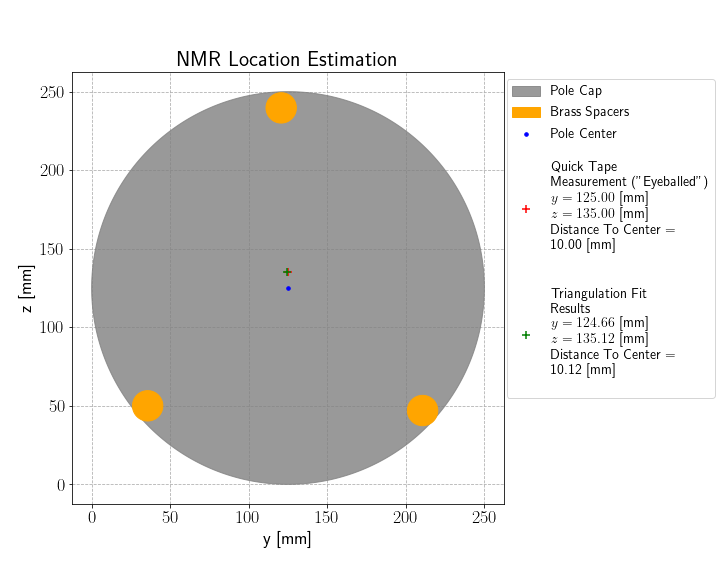

In [707]:
#fig, ax = plt.subplots()
fig = plt.figure()
ax = fig.add_axes((0.1, 0.1, 0.6, 0.8))
#ax2 = fig.add_axes((0.72, 0.08, 0.25, 0.8))

#ax.plot(ys, zs, label='Pole Cap', zorder=50)
ax.fill(ys, zs, label='Pole Cap', color='gray', alpha=0.8, zorder=50)

ax.scatter([125.], [125.], s=50, marker='.', color='blue', label='Pole Center', zorder=52)

for i, sta in enumerate(stations):
    y_ = sta[0] + spacer_diameter/2 * np.cos(ts)
    z_ = sta[1] + spacer_diameter/2 * np.sin(ts)
    l = None
    if i == 0:
        l = 'Brass Spacers'
    ax.fill(y_, z_, label=l, color='orange', zorder=51)
#ax.scatter(*stations.T, s=25, c='orange', label='Brass Spacers')
center = np.array([125., 125.])
d_est = np.linalg.norm(nmr_tape_est-center)
d_fit = np.linalg.norm(nmr_best_fit-center)

ax.scatter([nmr_tape_est[0]], [nmr_tape_est[1]], c='red', marker='+', s=50, zorder=53,
           label='\nQuick Tape\nMeasurement ("Eyeballed")\n'+rf'$y={nmr_tape_est[0]:0.2f}$'+' [mm]\n'+
          rf'$z={nmr_tape_est[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_est:0.2f} [mm]\n')
ax.scatter([nmr_best_fit[0]], [nmr_best_fit[1]], c='green', marker='+', s=50, zorder=54,
           label='\nTriangulation Fit\nResults\n'+rf'$y={nmr_best_fit[0]:0.2f}$'+' [mm]\n'+
          rf'$z={nmr_best_fit[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_fit:0.2f} [mm]\n')


ax.set_xlabel('y [mm]')
ax.set_ylabel('z [mm]')
ax.set_title('NMR Location Estimation')
ax.set_aspect('equal')
ax.legend(fontsize=14, bbox_to_anchor=(0.99,1.0), loc="upper left").set_zorder(100);
#ax2.legend(fontsize=14,).set_zorder(100) #bbox_to_anchor=(0.75,1.0), loc="upper left").set_zorder(100);
fig.savefig('NMR_loc_2.pdf', transparent=False)
fig.savefig('NMR_loc_2.png', transparent=False)

## Hall Probe Measurements
- Marked with an "+" the location of the Hall element behind the protective cover
- Measured distance from pole (with NMR) to Hall probe cover
- Measured distance from Hall probe cover to Hall element
- Using Hall probe cover plane (marked on each brass spacer), measured 2D distance Hall probe to brass spacer.
- Can use same 2D triangulation + add 3rd dimension measurement.

In [708]:
nmr_tape_est, nmr_best_fit

(array([125., 135.]), array([124.65620346, 135.11584042]))

In [709]:
spacer_diameter = 19.33 # mm, measured with micrometer
y_offset = 25 # mm, width of 80/2, tape measure
#spacers = np.array([
# all station units mm
stations = np.array([
    [51. + spacer_diameter/2 - y_offset, 50.],
    [136. + spacer_diameter/2 - y_offset, 230. + spacer_diameter/2],
    [226. + spacer_diameter/2 - y_offset, 47.]
    #[222. + spacer_diameter/2 - y_offset, 47.] # correction from tape
    #[223. + spacer_diameter/2 - y_offset, 47.] # correction from tape
])

meas_dists = np.array([97.51, 112.07, 105.82]) + spacer_diameter/2 # mm, measured with micrometer

# nmr_tape_est = np.array([125., 135.]) # maybe 135.5
# nmr_tape_est = np.array([125., 135.5]) # maybe 135.5

x0_hall = 30.60 # mm
x_offset_hall = 4.0 # mm

x_hall = x0_hall + x_offset_hall

In [710]:
meas_dists

array([107.175, 121.735, 115.485])

In [711]:
stations

array([[ 35.665,  50.   ],
       [120.665, 239.665],
       [210.665,  47.   ]])

In [712]:
model = lm.Model(loc2dist_2d, independent_vars=['stations'])
params = lm.Parameters()
params.add('y0', value=125., vary=True, min=0, max=250.)
params.add('z0', value=125., vary=True, min=0, max=250.)
result = model.fit(meas_dists, stations=stations, params=params)
hall_best_fit = np.array([result.params[f'{i}0'].value for i in ['y', 'z']])

In [713]:
result

In [714]:
ts = np.linspace(0, 2*np.pi, 501)
ys = 125. + 125.*np.cos(ts)
zs = 125. + 125.*np.sin(ts)

<IPython.core.display.Javascript object>


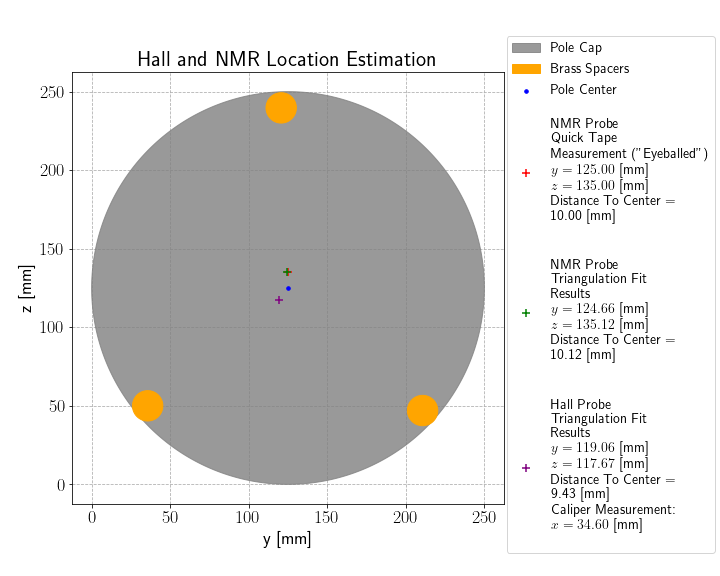

In [715]:
#fig, ax = plt.subplots()
fig = plt.figure()
ax = fig.add_axes((0.1, 0.1, 0.6, 0.8))
#ax2 = fig.add_axes((0.72, 0.08, 0.25, 0.8))

#ax.plot(ys, zs, label='Pole Cap', zorder=50)
ax.fill(ys, zs, label='Pole Cap', color='gray', alpha=0.8, zorder=50)

ax.scatter([125.], [125.], s=50, marker='.', color='blue', label='Pole Center', zorder=52)

for i, sta in enumerate(stations):
    y_ = sta[0] + spacer_diameter/2 * np.cos(ts)
    z_ = sta[1] + spacer_diameter/2 * np.sin(ts)
    l = None
    if i == 0:
        l = 'Brass Spacers'
    ax.fill(y_, z_, label=l, color='orange', zorder=51)
#ax.scatter(*stations.T, s=25, c='orange', label='Brass Spacers')
center = np.array([125., 125.])
d_est = np.linalg.norm(nmr_tape_est-center)
d_fit = np.linalg.norm(nmr_best_fit-center)
d_hall = np.linalg.norm(hall_best_fit-center)

ax.scatter([nmr_tape_est[0]], [nmr_tape_est[1]], c='red', marker='+', s=50, zorder=53,
           label='\nNMR Probe\nQuick Tape\nMeasurement ("Eyeballed")\n'+rf'$y={nmr_tape_est[0]:0.2f}$'+' [mm]\n'+
          rf'$z={nmr_tape_est[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_est:0.2f} [mm]\n')
ax.scatter([nmr_best_fit[0]], [nmr_best_fit[1]], c='green', marker='+', s=50, zorder=54,
           label='\nNMR Probe\nTriangulation Fit\nResults\n'+rf'$y={nmr_best_fit[0]:0.2f}$'+' [mm]\n'+
          rf'$z={nmr_best_fit[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_fit:0.2f} [mm]\n')

ax.scatter([hall_best_fit[0]], [hall_best_fit[1]], c='purple', marker='+', s=75, zorder=55,
           label='\nHall Probe\nTriangulation Fit\nResults\n'+rf'$y={hall_best_fit[0]:0.2f}$'+' [mm]\n'+
           rf'$z={hall_best_fit[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_hall:0.2f} [mm]\n'+
           'Caliper Measurement:\n'+rf'$x = {x_hall:0.2f}$ [mm]'+'\n'
          )


ax.set_xlabel('y [mm]')
ax.set_ylabel('z [mm]')
ax.set_title('Hall and NMR Location Estimation')
ax.set_aspect('equal')
ax.legend(fontsize=14, bbox_to_anchor=(0.99,1.1), loc="upper left").set_zorder(100);
#ax2.legend(fontsize=14,).set_zorder(100) #bbox_to_anchor=(0.75,1.0), loc="upper left").set_zorder(100);
fig.savefig('Hall_and_NMR_loc_2.pdf', transparent=False)
fig.savefig('Hall_and_NMR_loc_2.png', transparent=False)